In [262]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import pickle, os 
import warnings 
import seaborn as sns 
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding

from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping

# 試したこと
---
1. XGBoostのみ
2. NN
3. Stacking 

In [43]:
N = 4 
SEED = 42 
warnings.simplefilter("ignore")

T_BIL = 1.2 
ALP = 350.0 
GOT = 38 
GPT = 44 
TP = 6.5 # under 
ast_alt_ratio = 0.87 
alb = 3.9 # under 
ag = 1.0 # under 

In [8]:
train = pd.read_csv("./data/raw/train.csv")
test = pd.read_csv("./data/raw/test.csv")
train.drop("id", axis=1, inplace=True)
test.drop("id", axis=1, inplace=True)

train["Gender"] = train.Gender.map({"Male": 0, "Female": 1})
test["Gender"] = test.Gender.map({"Male": 0, "Female": 1})
train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease
0,42,0,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1
1,65,1,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0
2,29,0,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1
3,65,1,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0
4,59,0,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0


# 特長量の生成

In [ ]:
train["Ab_TBil"] = train.T_Bil.apply(lambda x: 1 if x >= T_BIL else 0)
test["Ab_TBil"] = test.T_Bil.apply(lambda x: 1 if x >= T_BIL else 0)

train["Ab_ALP"] = train.ALP.apply(lambda x: 1 if x >= ALP else 0)
test["Ab_ALP"] = test.ALP.apply(lambda x: 1 if x >= ALP else 0)

train["Ab_GOT"] = train.AST_GOT.apply(lambda x: 1 if x >= GOT else 0)
test["Ab_GOT"] = test.AST_GOT.apply(lambda x: 1 if x >= GOT else 0)

train["Ab_GPT"] = train.ALT_GPT.apply(lambda x: 1 if x >= GPT else 0)
test["Ab_GPT"] = test.ALT_GPT.apply(lambda x: 1 if x >= GPT else 0)

train["Ab_TP"] = train.TP.apply(lambda x: 1 if x < TP else 0)
test["Ab_TP"] = test.TP.apply(lambda x: 1 if x < TP else 0)

train["Ab_Alb"] = train.Alb.apply(lambda x: 1 if x < alb else 0)
test["Ab_Alb"] = test.Alb.apply(lambda x: 1 if x < alb else 0)

train["Ab_AG"] = train.AG_ratio.apply(lambda x: 1 if x < ag else 0)
test["Ab_AG"] = test.AG_ratio.apply(lambda x: 1 if x < ag else 0)

train["ast_alt"] = train.AST_GOT/train.ALT_GPT
test["ast_alt"] = test.AST_GOT/test.ALT_GPT

train["ast_alt"] = train.ast_alt.apply(lambda x: 1 if x >= ast_alt_ratio else 0)
test["ast_alt"] = test.ast_alt.apply(lambda x: 1 if x >= ast_alt_ratio else 0)

train.head()

# K分割

In [17]:
def k_split(train):
    kf = StratifiedKFold(n_splits=N, random_state=SEED, shuffle=True)
    for i, (tr_id, va_id) in enumerate(kf.split(train, train.disease)):
        train.loc[va_id, "fold"] = int(i)
    train["fold"] = train.fold.astype(np.uint8)
    return train 

train = k_split(train)
train.head()

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,Ab_TBil,Ab_ALP,Ab_GOT,Ab_GPT,Ab_TP,Ab_Alb,Ab_AG,ast_alt,fold
0,42,0,0.786362,0.154075,162.267801,26.053979,37.413395,6.041335,3.584788,0.793957,1,0,0,0,0,1,1,1,1,1
1,65,1,0.939515,0.174262,175.315396,14.346785,11.606569,6.249220,3.499155,0.954351,0,0,0,0,0,1,1,1,0,1
2,29,0,1.221597,0.374223,151.164721,13.226549,11.109054,6.752648,3.498901,1.065019,1,1,0,0,0,0,1,0,0,0
3,65,1,0.889107,0.122545,177.429034,15.376386,15.247101,6.333087,3.440847,0.953817,0,0,0,0,0,1,1,1,1,0
4,59,0,1.990933,0.603734,183.793499,23.202757,54.162685,6.128990,2.560995,0.958612,0,1,0,1,0,1,1,1,1,3


# Clustering 

In [30]:
use_cols = ['Ab_TBil', 'Ab_ALP', 'Ab_GOT', 'Ab_GPT','Ab_TP', 'Ab_Alb', 'Ab_AG', 'ast_alt']
km = KMeans(n_clusters=2, random_state=SEED)
y_km = km.fit_predict(train[use_cols])
y_km_ = km.predict(test[use_cols])

train["cluster"] = y_km 
test["cluster"] = y_km_ 

In [31]:
dfs = pd.DataFrame({"cluster": y_km, "disease": train.disease})
dfs.corr()

,cluster,disease
cluster,1.000000,-0.334013
disease,-0.334013,1.000000


Text(0.5, 1.0, 'cluster vs disease')

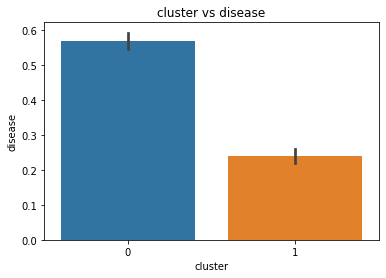

In [33]:
sns.barplot(data=train, x="cluster", y="disease")
plt.title("cluster vs disease")

In [37]:
# use_cols.append("cluster")
train[use_cols].groupby("cluster").mean()

,Ab_TBil,Ab_ALP,Ab_GOT,Ab_GPT,Ab_TP,Ab_Alb,Ab_AG,ast_alt
cluster,,,,,,,,
0,0.414488,0.139434,0.412854,0.228758,0.864924,0.975490,0.857298,0.791939
1,0.064904,0.022236,0.085337,0.039663,0.095553,0.115986,0.638822,0.902644


# Model 
## XGBOOST 
---

In [44]:
def logger(pred, y_val, fold, is_print=True):
    if is_print:
        error = log_loss(pred, y_val.values.ravel())
        acc = accuracy_score(pred.ravel(), y_val.values.ravel())
        print(
            f"Fold: {fold} | Loss: {error:.3f} | Accuracy: {acc:.3f}"
        )
        return error, acc, fold
    else:
        with open("xgb.log", "wb") as f:
            pickle.dump(pred, f)
     
def checkpoint(model, fold):
    model.save_model(f"models/xgb{fold}.model")
    print("successful saving model")

def train_xgb(train):
    param = {
        "max_depth": [1, 3, 5, 8, 10],
        "colsample_bytree": [1, 3, 5, 8, 10],
        "eta": [0.001, 0.01, 0.1, 1.0, 10.0]
    }
    predict_proba = []
    total_result = []
    result = {}
    for i in range(N):
        tr, va = train[train.fold != i], train[train.fold == i]
        x_train, y_train = tr.drop(["disease", "fold"], axis=1), tr[["disease"]]
        x_val, y_val = va.drop(["disease", "fold"], axis=1), va[["disease"]]        
        
        grid = GridSearchCV(XGBClassifier(random_state=SEED), param_grid=param, cv=4).fit(x_train, y_train)
        model = XGBClassifier(random_state=SEED, 
                              **grid.best_params_,
                              eval_set=[(x_train, y_train), (x_val, y_val)], 
                              ealry_stopping_rounds=30).fit(x_train, y_train)
        pred = model.predict(x_val)
        proba = model.predict_proba(x_val)[:, 1]
        predict_proba.append(proba)
        error, acc, fold_ = logger(pred, y_val, i)
        result[fold_] = {
            "error": error, 
            "accuracy": acc
        }
        total_result.append(result)
        checkpoint(model, i)
        
    predict_proba = np.concatenate(predict_proba, axis=0).tolist()
    logger(total_result, None, None, is_print=False)
    return predict_proba 

In [45]:
proba = train_xgb(train)

[15:15:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:15:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

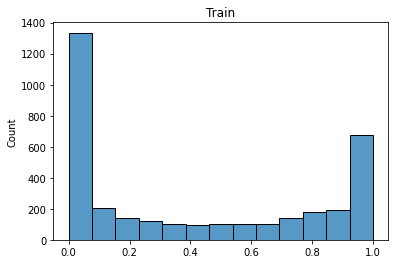

In [47]:
sns.histplot(proba)
plt.title("Train")
plt.show()

In [68]:
def predict_fn(test):
    root = "models"
    predict = []
    predict_proba = []
    for i in range(N):
        model_path = os.path.join(root, f"xgb{i}.model")
        model = XGBClassifier(random_state=SEED)
        model.load_model(model_path)
        predict.append(model.predict(test))
        predict_proba.append(model.predict_proba(test)[:, 1])
        
    predict = np.mean(predict, axis=0)
    predict = np.where(predict >= 0.5, 1, 0).astype(np.uint8).tolist()
    predict_proba = np.mean(predict_proba, axis=0).tolist()
    try:
        submit(predict_proba)
    finally:
        del model 
        return predict, predict_proba
    
def submit(pred):
    sub = pd.read_csv("./data/raw/sample_submit.csv", header=None, names=["id", "pred"])
    sub["pred"] = pred 
    sub.to_csv("./data/submit/0920XGB.csv", header=False, index=False)
        

In [69]:
tr_cols = train.drop(["fold", "disease"], axis=1).columns
test = test[tr_cols]
pred, proba = predict_fn(test)

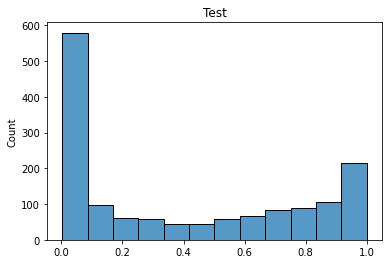

In [67]:
sns.histplot(proba)
plt.title("Test")
plt.show()

## NN

In [115]:
def Net(input_size: int):
    model = Sequential()
    model.add(Dense(256, activation="relu", input_shape=(input_size, )))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model 

def scaler(train, val, test):
    cols = train.columns 
    s = StandardScaler()
    train_s, val_s, test_s = s.fit_transform(train), s.transform(val), s.transform(test)
    train_s = pd.DataFrame(train_s, columns=cols)
    val_s = pd.DataFrame(val_s, columns=cols)
    test_s = pd.DataFrame(test_s, columns=cols)
    return train_s, val_s, test_s


def logger(proba, y_val, fold, is_print=True):
    if is_print:
        error = log_loss(y_val.values.ravel(), proba)
        acc = roc_auc_score(np.where(proba >= 0.5, 1, 0).astype(np.uint8), y_val.values.ravel())
        print(
            f"Fold: {fold} | Loss: {error:.4f} | Accuracy: {acc:.4f}"
        )
        return error, acc 
    else:
        with open("nn.log", "wb") as f:
            pickle.dump(proba, f)
            
def checkpoint(model, fold):
    model.save_weights(f"models/nn{fold}.ckpt")
    print("successfully saving model")
    
def submit(pred):
    sub = pd.read_csv("./data/raw/sample_submit.csv", header=None, names=["id", "pred"])
    sub["pred"] = pred 
    sub.to_csv("./data/submit/0920NN.csv", header=False, index=False) 

def train_predict_nn(train, test):
    train_ = train.copy()
    test_ = test.copy()
    total_proba, test_proba = [], []
    result = {}
    for fold in range(N):
        net = Net(train.drop(["fold", "disease"], axis=1).shape[1])
        tr, va = train_[train_.fold != fold], train_[train_.fold == fold]
        x_train, y_train = tr.drop(["fold", "disease"], axis=1), tr[["disease"]]
        x_val, y_val = va.drop(["fold", "disease"], axis=1), va[["disease"]]
        x_train_, x_val_, x_test = scaler(x_train, x_val, test_)
        
        early_stopping = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
        net.fit(x_train_, y_train, validation_data=(x_val_, y_val), 
                callbacks=[early_stopping], batch_size=32
                , epochs=100, verbose=1)
        
        proba = net.predict(x_val_).ravel()
        proba_test = net.predict(x_test).ravel()
        error, acc = logger(proba, y_val, fold)
        total_proba.append(proba)
        test_proba.append(proba_test)
        
        result[fold] = {
            "error": error, 
            "accuracy": acc 
        }
        checkpoint(net, fold)
        
    total_proba = np.concatenate(total_proba, axis=0).tolist()
    test_proba = np.mean(test_proba, axis=0).tolist()
    logger([result], None, None, is_print=False)
    
    try:
        submit(test_proba)
    finally:
        del net 
        return total_proba, test_proba 
    
    

In [116]:
tr_proba, te_proba = train_predict_nn(train, test)

Epoch 1/100
83/83 [==============================] - 1s 5ms/step - loss: 0.5142 - accuracy: 0.7349 - val_loss: 0.4705 - val_accuracy: 0.7623
Epoch 2/100
83/83 [==============================] - 0s 4ms/step - loss: 0.4772 - accuracy: 0.7600 - val_loss: 0.4618 - val_accuracy: 0.7691
Epoch 3/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4701 - accuracy: 0.7589 - val_loss: 0.4612 - val_accuracy: 0.7749
Epoch 4/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4532 - accuracy: 0.7756 - val_loss: 0.4556 - val_accuracy: 0.7657
Epoch 5/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4524 - accuracy: 0.7741 - val_loss: 0.4519 - val_accuracy: 0.7794
Epoch 6/100
83/83 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.7810 - val_loss: 0.4555 - val_accuracy: 0.7691
Epoch 7/100
83/83 [==============================] - 0s 4ms/step - loss: 0.4339 - accuracy: 0.7817 - val_loss: 0.4516 - val_accuracy: 0.7737
Epoch 8/100
8

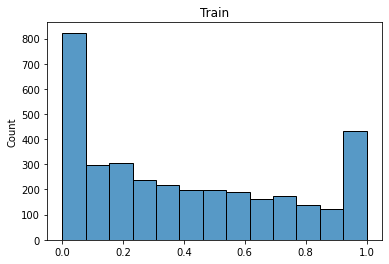

In [119]:
sns.histplot(tr_proba)
plt.title("Train")
plt.show()

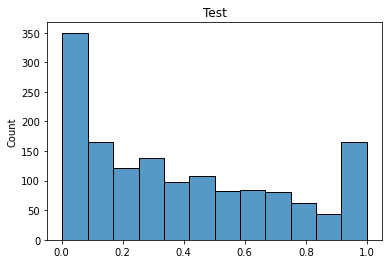

In [120]:
sns.histplot(te_proba)
plt.title("Test")
plt.show()

In [127]:
a = pd.read_csv("./data/submit/0920XGB.csv", header=None, names=["id", "pred"])
a 

,id,pred
0,3500,0.625758
1,3501,0.502444
2,3502,0.912111
3,3503,0.985357
4,3504,0.706056
...,...,...
1495,4995,0.739077
1496,4996,0.401565
1497,4997,0.915651
1498,4998,0.397992


In [130]:
pred = (a["pred"] + te_proba) / 2 
a["pred"] = pred 
a.to_csv("0920ensemble.csv", header=False, index=False)

# Stacking 

In [259]:
def model_layers(seed=SEED, input_size=test.shape[1]):
    clfs = []
    clfs.append(("XGBClassifier", Pipeline([
        ("XGB", XGBClassifier(n_jobs=-1, random_state=seed))
    ])))
    clfs.append(("SVC", Pipeline([
        ("SVC", SVC(random_state=seed))
    ]))) 
    clfs.append(("DecisionTreeClassifier", Pipeline([
        ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=seed))
    ]))) 
    clfs.append(("RandomForestClassifier", Pipeline([
        ("RandomForestClassifier", RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=seed))
    ]))) 
    clfs.append(("RidgeClassifier", Pipeline([
        ("RidgeClassifier", RidgeClassifier(random_state=seed))
    ]))) 
    clfs.append(("NN", Pipeline([
        ("NN", Net(input_size))
    ]))) 
    clfs.append(("ExtraTreesClassifier", Pipeline([
        ("ExtraTreesClassifier", ExtraTreesClassifier(n_jobs=-1, random_state=seed))
    ])))
    clfs.append(("BaggingRidgeClassifier",Pipeline([
        ("BaggingClassifier", BaggingClassifier(n_jobs=-1, random_state=42))
    ])))
    return clfs 

class Layer1:
    def __init__(self):
        self.models = model_layers()
        
    def _scaler(self, train, val, test):
        s = StandardScaler()
        s.fit(train)
        train_s, val_s, test_s = s.transform(train), s.transform(val), s.transform(test)
        return train_s, val_s, test_s
    
    def _logger(self, name, pred, y_val, fold):
        if name == "NN":
            acc = accuracy_score(np.where(pred >= 0.5, 1, 0), y_val.values.ravel())
        else:
            acc = accuracy_score(pred, y_val.values.ravel())
        error = log_loss(y_val.values.ravel(), pred)
        print(
            f"Model: {name} | Fold: {fold} | Loss: {error:.4f}| accuracy: {acc:.4f}"
        )
        
    def train(self, train, test):
        df_list, df_test = pd.DataFrame(), pd.DataFrame()
        fold_list = train["fold"].values.ravel()
        for name, model in self.models:
            train_ = train.copy()
            test_ = test.copy()
            predict_val, predict_test, val_idx_list = [], [], []
            for fold in range(N):
                tr, va = train_[train_.fold != fold], train_[train_.fold == fold]
                va_idx = va.index 
                x_train, x_val = tr.drop(["fold", "disease"], axis=1), va.drop(["fold", "disease"], axis=1)
                y_train, y_val = tr[["disease"]], va[["disease"]]
                x_train, x_val, x_test = self._scaler(x_train, x_val, test)
                
                pred_val, pred_test = self._predict(model, x_train, y_train, x_val, x_test, name)
                self._logger(name, pred_val, y_val, fold)
                predict_val.append(pred_val)
                predict_test.append(pred_test)
                val_idx_list.append(va_idx)
                
            predict_val = np.concatenate(predict_val, axis=0)
            val_idx_list = np.concatenate(val_idx_list)
            val_idx_list = np.argsort(val_idx_list)
            predict_val_ = predict_val[val_idx_list]
            predict_test = np.mean(predict_test, axis=0)
            
            df_list[f"{name}_feature"] = predict_val_.tolist()
            df_test[f"{name}_feature"] = predict_test.tolist()
            
        df_list["fold"] = fold_list
        df_list["disease"] = train["disease"].values.ravel()
        del predict_val_, predict_test, predict_val, model 
        return df_list, df_test  
                
    def _predict(self, model, x_train, y_train, x_val, x_test, name):
        model.fit(x_train, y_train)
        pred_val = model.predict(x_val).ravel()
        if name:
            pred_val = np.where(pred_val >= 0.5, 1, 0)
        pred_test = model.predict(x_test).ravel()
        if name:
            pred_test = np.where(pred_test >= 0.5, 1, 0)
        return pred_val, pred_test
        
class Layer2:
    def __init__(self):
        self.param = {
            "max_depth": [1, 3, 5, 8, 10],
            "colsample_bytree": [1, 3, 5, 8, 10],
            "eta": [0.001, 0.01, 0.1, 1.0, 10.0]
        }
        
    def logger(self, pred, y_val, fold):
        error = log_loss(np.where(pred >= 0.5, 1, 0), y_val.values.ravel())
        acc = accuracy_score(np.where(pred >= 0.5, 1, 0), y_val.values.ravel())
        print(
            f"Fold: {fold}| Loss: {error:.3f}| acc: {acc:.3f}"
        )
    def checkpoint(self, model, fold):
        model.save_model(f"models/stacking{fold}.model")
        print("successfully saving model")
        
    def train(self, train):
        total_pred, val_idx_list = [], []
        for fold in range(N):
            tr, va = train[train.fold != fold], train[train.fold == fold]
            va_idx = va.index 
            x_train, x_val = tr.drop(["fold", "disease"], axis=1), va.drop(["fold", "disease"], axis=1)
            y_train, y_val = tr[["disease"]], va[["disease"]]
            
            grid = GridSearchCV(XGBClassifier(random_state=SEED), param_grid=self.param, cv=3).fit(x_train, y_train)
            model = XGBClassifier(random_state=SEED, **grid.best_params_, 
                                  eval_set=[(x_train, y_train), (x_val, y_val)], early_stopping_rounds=30).fit(x_train, y_train)
            pred = model.predict_proba(x_val)[:, 1]
            self.logger(pred, y_val, fold)
            self.checkpoint(model, fold)
            total_pred.append(pred)
            val_idx_list.append(va_idx)
        del model
        val_idx_list = np.concatenate(val_idx_list)
        val_idx_list = np.argsort(val_idx_list)
        total_pred = np.concatenate(total_pred, axis=0)
        total_pred = total_pred[val_idx_list].tolist()
        return total_pred
        

In [260]:
layer_first = Layer1()
layer_second = Layer2()

In [240]:
df_train, df_test = layer_first.train(train, test)

[18:30:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBClassifier | Fold: 0 | Loss: 5.2105| accuracy: 0.8491
[18:30:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBClassifier | Fold: 1 | Loss: 6.0394| accuracy: 0.8251
[18:30:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model: XGBClassifier | Fold: 2 | Loss: 5.9999| accuracy: 0.8263
[18:30:19] WARNING: ../src/learner.cc:1095: Starting

In [241]:
df_train.head()

,XGBClassifier_feature,SVC_feature,DecisionTreeClassifier_feature,RandomForestClassifier_feature,RidgeClassifier_feature,NN_feature,ExtraTreesClassifier_feature,BaggingRidgeClassifier_feature,fold,disease
0,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,1,0
2,1,1,1,1,1,1,1,1,0,1
3,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,1,1,1,1,3,0


In [242]:
df_test.head()

,XGBClassifier_feature,SVC_feature,DecisionTreeClassifier_feature,RandomForestClassifier_feature,RidgeClassifier_feature,NN_feature,ExtraTreesClassifier_feature,BaggingRidgeClassifier_feature
0,0.5,1.00,0.5,1.0,1.0,1.0,1.00,0.25
1,1.0,1.00,1.0,1.0,1.0,1.0,1.00,0.50
2,1.0,0.25,1.0,1.0,0.0,1.0,1.00,1.00
3,1.0,1.00,1.0,1.0,1.0,1.0,1.00,1.00
4,0.5,0.00,1.0,1.0,0.0,0.0,0.75,1.00


In [212]:
use_cols = df_train.drop(["fold", "disease"], axis=1).columns 

# T-SNE

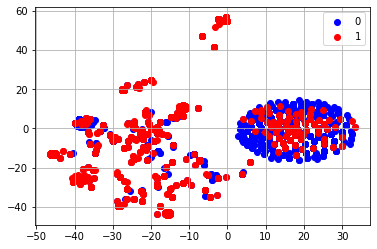

In [213]:
tsne = TSNE(n_components=2, random_state=SEED)
x, t = tsne.fit_transform(df_train[use_cols]), tsne.fit_transform(df_test[use_cols])

y = df_train["disease"].values.ravel()
plt.scatter(x=x[:, 0][y == 0], y=x[:, 1][y == 0], c="b")
plt.scatter(x=x[:, 0][y == 1], y=x[:, 1][y == 1], c="r")
plt.legend(["0", "1"])
plt.grid()
plt.show()

In [214]:
dfs = pd.DataFrame(x, columns=["c1", "c2"])
dfs["disease"] = df_train["disease"].values.ravel()
dfs.corr()

,c1,c2,disease
c1,1.000000,0.182441,-0.421155
c2,0.182441,1.000000,0.261569
disease,-0.421155,0.261569,1.000000


In [215]:
df_train["c1"] = x[:, 0]
df_train["c2"] = x[:, 1]
df_test["c1"] = t[:, 0]
df_test["c2"] = t[:, 1]

# PCA 

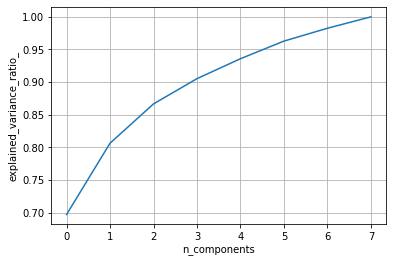

In [247]:
pca = PCA()
pca.fit(df_train[use_cols])

plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(range(8))
plt.xlabel("n_components")
plt.ylabel("explained_variance_ratio_")
plt.grid()
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


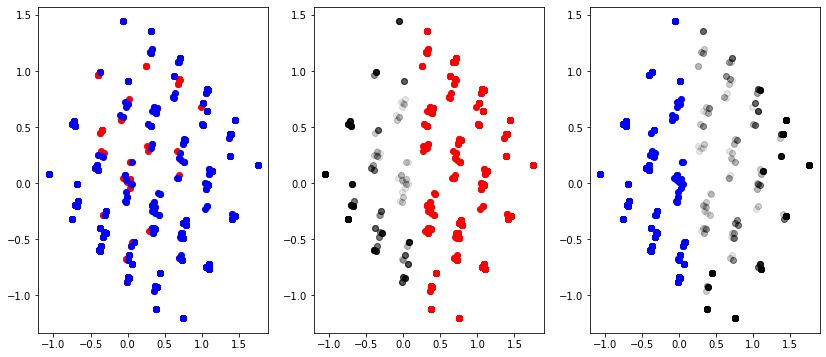

In [252]:
pca = PCA(n_components=2, random_state=SEED)
x, t = pca.fit_transform(df_train[use_cols]), pca.transform(df_test)

km = KMeans(n_clusters=2, random_state=SEED).fit(x)
y_km, y_km_ = km.predict(x), km.predict(t)

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
ax = axes.ravel()
y = df_train["disease"].values.ravel()
ax[0].scatter(x=x[:, 0][y == 0], y=x[:, 1][y == 0], c="r")
ax[0].scatter(x=x[:, 0][y == 1], y=x[:, 1][y == 1], c="b")
ax[1].scatter(x=x[:, 0], y=x[:, 1], c=(0, 0, 0), alpha=0.1)
ax[1].scatter(x=x[:, 0][y_km == 0], y=x[:, 1][y_km == 0], c="r")
ax[2].scatter(x=x[:, 0], y=x[:, 1], c=(0, 0, 0), alpha=0.1)
ax[2].scatter(x=x[:, 0][y_km == 1], y=x[:, 1][y_km == 1], c="b")

In [253]:
df_train["cluster"] = y_km
df_test["cluster"] = y_km_ 

df_train[["cluster", "disease"]].corr().style.background_gradient(cmap="coolwarm")

,cluster,disease
cluster,1.000000,-0.673877
disease,-0.673877,1.000000


# Train Layer2 

In [261]:
stck_pred = layer_second.train(df_train)

[18:50:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:50:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'ROC: 0.8629')

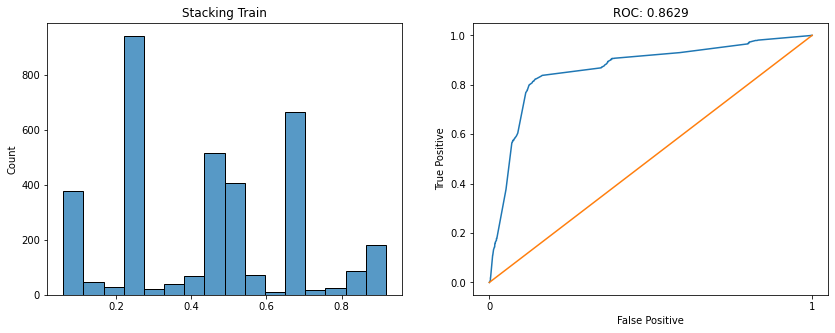

In [271]:
y = df_train["disease"].values.ravel().tolist()
fpr, tpr, _ = roc_curve(y, stck_pred)
roc = roc_auc_score(y, stck_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax = axes.ravel()
sns.histplot(stck_pred, ax=ax[0])
ax[0].set_title("Stacking Train")
ax[1].plot(fpr, tpr)
ax[1].plot([0, 1])
ax[1].set_xlabel("False Positive")
ax[1].set_ylabel("True Positive")
ax[1].set_xticks([0, 1])
ax[1].set_title(f"ROC: {roc:.4f}")

In [256]:
def predict_fn(test):
    root = "models"
    total_pred = []
    for fold in range(N):
        model_path = os.path.join(root, f"stacking{fold}.model")
        model = XGBClassifier(random_state=SEED)
        model.load_model(model_path)
        pred = model.predict_proba(test)[:, 1]
        total_pred.append(pred)
    return np.mean(total_pred, axis=0).tolist()
        
    
def submit(test):
    pred = predict_fn(test)
    sub = pd.read_csv("./data/raw/sample_submit.csv", header=None, names=["id", "pred"])
    sub["pred"] = pred 
    sub.to_csv("./data/submit/0920Stacking.csv", index=False, header=False)
    return pred 

In [257]:
col = df_train.drop(["fold", "disease"], axis=1).columns 
df_test = df_test[col]
stck_test = submit(df_test)

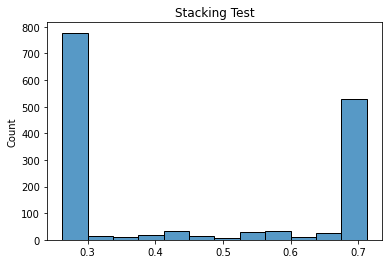

In [258]:
sns.histplot(stck_test)
plt.title("Stacking Test")
plt.show()